# XGBoost

## Load data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "preprocessing"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    train = pickle.load(file)
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    test = pickle.load(file)

In [3]:
print(train.shape)
train.head()

(523021, 75)


,StoreID,Date,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Hol_and_open,Region_PD,stores_per_region,stores_per_person,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,semester,Events_Hail,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Rain,Events_Snow,Events_Thunderstorm,Events_Normal,Region,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter,NumberOfSales
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1000,2016-03-01,False,True,False,326,9643,17130,2770,8.0,1,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.0,23,False,0.287255,62,0.022383,0,2016,1,3,1,1,61,9,31,1,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,5,5676
1,1000,2016-03-02,False,True,False,326,9643,17130,2770,8.0,0,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.0,56,False,0.287255,62,0.022383,0,2016,1,3,2,2,62,9,31,1,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,7,0,0,0,0,0,5,8111
2,1000,2016-03-04,False,True,False,326,9643,17130,2770,8.0,0,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.0,22,False,0.287255,62,0.022383,0,2016,1,3,4,4,64,9,31,1,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,7,0,0,0,0,0,5,8300
3,1000,2016-03-05,False,True,False,326,9643,17130,2770,6.0,-3,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.0,108,False,0.287255,62,0.022383,0,2016,1,3,5,5,65,9,31,1,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,7,0,0,0,0,0,5,7154
4,1000,2016-03-06,False,False,False,326,9643,17130,2770,6.0,0,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.0,46,False,0.287255,62,0.022383,0,2016,1,3,6,6,66,9,31,1,False,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,7,0,0,0,0,0,5,0


## Utilities

In [4]:
# categorized feature lists to ease the preprocessing
filter_startswith = lambda l,s: [x for x in l if x.startswith(s)]

# regional features
r_regions = ['Region_'+str(i) for i in range(11)]
r_assortments = filter_startswith(train.columns, 'AssortmentType_')
r_storetype = filter_startswith(train.columns, 'StoreType_')
r_general = ['NearestCompetitor', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'Region_PD',
             'stores_per_region', 'stores_per_person']
regional_features =  r_regions + r_assortments + r_storetype + r_general

# meteo features
m_events = filter_startswith(train.columns, 'Events_')
m_general = ['CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa',
             'Max_TemperatureC', 'Max_VisibilityKm', 'Max_Wind_SpeedKm_h',
             'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
             'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h',
             'Min_Dew_PointC', 'Min_Humidity', 'Min_Sea_Level_PressurehPa',
             'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm',
             'WindDirDegrees']
meteo_features =  m_events + m_general

# store features
store_features = ['IsHoliday', 'IsOpen', 'HasPromotions', 'Hol_and_open']

# seasonal features
seasonal_features = ['week_of_month', 'year', 'quarter', 'month', 'day_of_month',
                     'day_of_week', 'day_of_year', 'WeekOfYear', 'days_in_month',
                     'HolidaysWeekBefore', 'HolidaysWeekCurrent', 'HolidaysWeekAfter',
                     'PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter']

# x and y specific
x_features = ['StoreID']
y_features = ['NumberOfSales']

In [5]:
# split train set in x and y
def split_dataset(dataset):
    x = dataset.drop('NumberOfSales', axis=1)
    y = dataset.NumberOfSales
    
    return (x, y)

# split train set by months
def split_dataset_bymonth(test_year, test_months, train_set):
    test_mask = (train_set.year == test_year) & train_set.month.isin(test_months)

    # define the train set
    train_dataset = train_set[~test_mask]
    x_train, y_train = split_dataset(train_dataset)
    
    # define the test set
    test_dataset = train_set[test_mask]
    x_test, y_test = split_dataset(test_dataset)
    
    return (x_train, y_train, x_test, y_test)

In [6]:
# reorder results monthly wrt regions, stores pairing predictions with actual values
def get_regional_results(results, x, y=0):
    # create the dataframe and round predicted values to int
    df_results = x[['StoreID', 'month'] + r_regions].copy()
    df_results['predicted'] = results.astype(int)
    
    # create 'actual' values column if passed
    if isinstance(y, int):
        agg_dict = {'predicted': 'sum'}
    else:
        agg_dict = {'predicted': 'sum', 'actual': 'sum'}
        df_results['actual'] = y.astype(int)
    
    # aggregate prediction monthly
    df_results = df_results.groupby(['StoreID', 'month']+r_regions)\
    .agg(agg_dict).reset_index()
    
    # reverse region one-hot-encoding
    df_results['region'] = df_results[r_regions].idxmax(axis=1)\
    .map(lambda x: str(x).replace('Region_', ''))
    df_results = df_results.drop(r_regions, axis=1)
    
    df_results = df_results.sort_values(by=['region', 'StoreID', 'month'])\
    .reset_index().drop('index', axis=1)    
    
    return df_results

# format format suitable for the submission of the project
def get_submission_format(regional_results):
    submit_results = regional_results.copy()
    
    # drop region column and reorder wrt storeid and month
    submit_results = submit_results.drop('region', axis=1)\
    .sort_values(by=['StoreID', 'month'])\
    .reset_index().drop('index', axis=1)
    
    return submit_results

In [7]:
# Lanzi error

# Regional error
# DataFrame: 'StoreID' 'month' 'predicted' 'actual' 'region'
def lanzi_region_error(region):
    num = region[['actual', 'predicted']].apply(lambda x: abs(x[0] - x[1]), axis=1).sum()
    den = region['actual'].sum()
    
    return num/den
    
# Total error across all regions
# region_errors = [0.3, 0.5, ... ]
def lanzi_total_error(region_errors):
    return sum(region_errors)/len(region_errors)

def lanzi_error(regional_results):
    region_errors = []
    for regionid, region in regional_results.groupby('region'):
        region_errors.append(lanzi_region_error(region))
    
    return (region_errors, lanzi_total_error(region_errors))

# Print results of Lanzi error
def lanzi_print(r_error, t_error):
    print('LANZI ERROR')
    print('-' * 20) 
    print('{:<10}{:>10}'.format('REGION', 'ERROR'))
    
    for regionid, error in enumerate(r_error):
        print('{:<10}{:>10.4f}'.format(regionid, error))
    print('-' * 20)
    print('{:<10}{:>10.4f}'.format('TOTAL', t_error))

## Preprocessing

In [8]:
# Robust Scaler
rs = RobustScaler()

features_to_scale = r_general + m_general

train[features_to_scale] = rs.fit_transform(train[features_to_scale])
test[features_to_scale] = rs.fit_transform(test[features_to_scale])

In [9]:
# drop useless features
features_to_drop = m_general + ['Region', 'Date']

train = train.drop(labels=features_to_drop, axis=1)
test = test.drop(labels=features_to_drop, axis=1)

## Train and predict

In [10]:
# settings
xgboost_params = {    
    'max_depth': 12,
    'learning_rate': 0.2,
    'n_jobs': 4,
    'silent': False
}

kfold_params = {
    'n_splits': 2,
    'shuffle': True,
    'random_state': 42
}

In [11]:
# Cross validation score
x_train, y_train = split_dataset(train)

model = XGBRegressor(**xgboost_params)
kfold = KFold(**kfold_params)
results = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold, verbose=2)

print('Cross-validation score: {:.4f} with +/- {:.4f}'\
      .format(results.mean(),results.std()))

[CV]  ................................................................
[CV] ................................................. , total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] ................................................. , total= 2.8min
Cross-validation score: 0.9640 with +/- 0.0006


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min finished


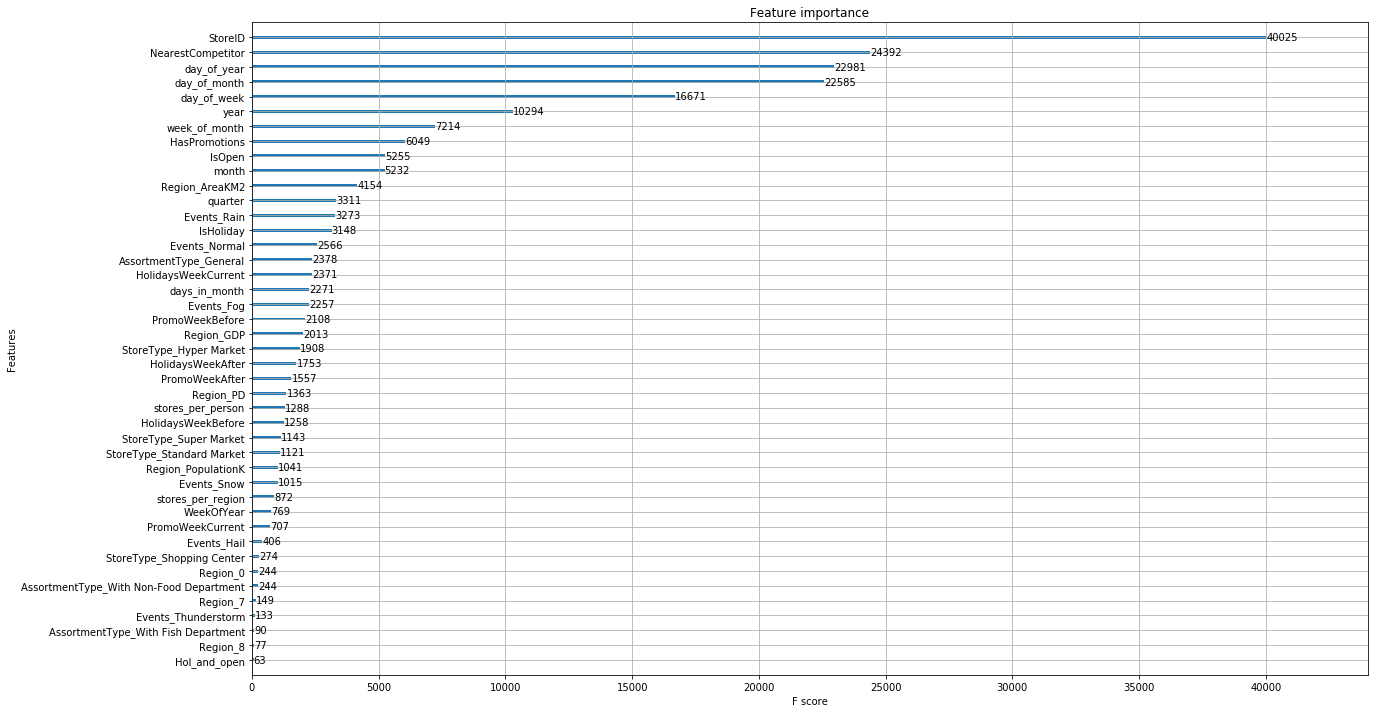

In [12]:
# Feature importance plot
model.fit(x_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(model, ax=ax)
plt.show()

In [13]:
# results = {}
# for storeid in all_train.StoreID.unique():
#     train = all_train[all_train.StoreID == storeid]
#     y_train = train.NumberOfSales
#     x_train = train.drop('NumberOfSales',axis = 1)
    
#     model = XGBRegressor(silent=False)
#     kfold = KFold(n_splits=10, shuffle = True, random_state=7)
#     results[storeid] = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
#     print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
#           .format(storeid,results[storeid].mean(),results[storeid].std()))

In [14]:
# df_results = pd.DataFrame.from_dict(results).T
# df_results_mean = df_results.mean(axis=1)
# df_results_mean[df_results_mean < 0.8]

## Lanzi Error

In [15]:
# Split train set and predict the test set
x_train, y_train, x_test, y_test =\
    split_dataset_bymonth(2017, [3, 4], train)

model = XGBRegressor(**xgboost_params)
model.fit(x_train, y_train)

results = model.predict(x_test)

In [16]:
# get monthly results ordered by region, store and month
regional_results = get_regional_results(results, x_test, y_test)
regional_results.head()

,StoreID,month,predicted,actual,region
0,1001,3,70086,70708,0
1,1001,4,65047,67093,0
2,1009,3,135087,130890,0
3,1009,4,117929,116915,0
4,1019,3,114326,113892,0


In [17]:
# get lanzi error and print results
r_error, t_error = lanzi_error(regional_results)
lanzi_print(r_error, t_error)

LANZI ERROR
--------------------
REGION         ERROR
0             0.0299
1             0.0291
2             0.0361
3             0.0335
4             0.0328
5             0.0346
6             0.0307
7             0.0354
8             0.0355
9             0.0286
10            0.0326
--------------------
TOTAL         0.0326


## Score submit

In [18]:
# Split train set and predict the submission test set
x_train, y_train = split_dataset(train)

model = XGBRegressor(**xgboost_params)
model.fit(x_train, y_train)

submit_results = model.predict(test)

In [19]:
# get monthly results and format it for submission
submit_regional_results = get_regional_results(submit_results, test)
df_submission = get_submission_format(submit_regional_results)

print(df_submission.shape)
df_submission.head()

(706, 3)


,StoreID,month,predicted
0,1025,3,133931
1,1025,4,132253
2,1028,3,123250
3,1028,4,120768
4,1034,1,279595


In [20]:
# write submission csv
df_submission.to_csv(data_path_out+'submission.csv', index=False)